# HW1: Frame-Level Speech Recognition

In this homework, you will be working with MFCC data consisting of 28 features at each time step/frame. Your model should be able to recognize the phoneme occured in that frame.

# Schedule:
- Checkpoint Submission (DUE 23 January 2026 @ 11:59PM EST)
- Final Submission (DUE 6 February 2026 @ 11:59PM EST | Slack Deadline is 13 February 2026 @ 11:59PM EST)
- Code Submission (DUE 8 February 2026 @ 11:59PM EST OR Day-of Slack submission)


## Requirement Acknowledgement
Setting the below flag to True indicates full understanding and acceptance of the following:
1. Slack days may ONLY be used on P2 FINAL (not checkpoint) submission. I.e. you may use slack days to submit final P2 kaggle scores (such as this one) later on the **SLACK KAGGLE COMPETITION** at the expense of your Slack days.
2. The final autolab **code submission is due 48 hours after** the conclusion of the Kaggle Deadline (or, the same day as your final kaggle submission).
3. We will require your kaggle username here, and then we will pull your official PRIVATE kaggle leaderboard score. This submission may result in slight variance in scores/code, but we will check for acceptable discrepancies. Any discrepancies related to modifying the submission code (at the bottom of the notebook) will result in an AIV.
4. You are NOT allowed to use any code that will pre-load models (such as those from Hugging Face, etc.).
   You MAY use models described by papers or articles, but you MUST implement them yourself through fundamental PyTorch operations (i.e. Linear, Conv2d, etc.).
5. You are NOT allowed to use any external data/datasets at ANY point of this assignment.
6. You may work with teammates to run ablations/experiments, BUT you must submit your OWN code and your OWN results.
7. Failure to comply with the prior rules will be considered an Academic Integrity Violation (AIV).
8. Late submissions MUST be submitted through the Slack Kaggle (see writeup for details). Any submissions made to the regular Kaggle after the original deadline will NOT be considered, no matter how many slack days remain for the student.

In [1]:
ACKNOWLEDGED = True #TODO: Only set Acknowledged to True if you have read the above acknowlegements and agree to ALL of them.

# Dataset Description

Let's start by understanding the dataset for this homework.

Our data consists of 3 folders (train-clean-100, dev-clean and test-clean). The training and validation datasets (train-clean-100 and dev-clean) each contain 2 subfolders (mfcc and transcript). The 'mfcc' subfolder contains mel spectrograms (explained below and in writeup), while the 'transcript' subfolder contains their corresponding transcripts. However, the test dataset (test-clean) contains only the 'mfcc' subfolder without the corresponding transcripts, which will later be predicted by your model.


## 1. Audio Representation.
The 'mfcc' subfolders contain many `*.npy` files of mel spectrograms. .npy files are used to store numpy arrays.

Each .npy file represents a short speech recording. For example, one recording might be someone saying, "This is the age of AI." This recording is converted into a mel spectrogram, which is used to represent all forms of audio signals in a computer. Such representation is important in signal and speech processing tasks, especially in machine learning.

Compared to raw audio, mel spectrograms are better for speech processing because they capture both the timing and the frequencies of the sound. At each moment in time, they show which frequencies are present in the sound. This makes it easier for computers to understand and process speech.

When converting raw audio to spectrograms, you do not process the whole audio at once. Instead, you process small frames at a time as you stride over the entire audio length. This means that if you have an audio file of 100 seconds, you may decide to process 10 seconds at a time, striding by one second. In this case, the frame size is 10 seconds. The frame size and the number of timesteps (seconds, milliseconds, etc.) depend on individual choice.

When processing each frame, you extract a number of features that represent that frame's audio. For instance, in the audio recording of "This is the age of AI," the frame corresponding to "AI" will have features that represent how "AI" is pronounced, the vocal tract, and the effect of the environment in which it was recorded. For clarity, when we say features, you should think of columns. One feature/column may have information about the gender of the person who made the speech. Another may have information about the age of the person. Another may have information about the environment where the speech was recorded. Basically, the main properties that make up a speech are encoded in those features, which combine in some way to make the audio.

Since we want to recognize the word as it was pronounced despite the environment and other variabilities, we usually normalize to eliminate or minimize such effects.

Our spectrograms contain 28 features. Essentially, the number of features may be different. They may depend on how the raw audio data was converted into mel spectrograms.

## 2. Transcripts
Remember where we mentioned frames? Well, in our dataset, audio frames have corresponding target transcripts. For instance the abbreviation "AI", in our example above, if present in the recordings, will have transcripts: /eɪ aɪ/. This means that you will have two frames one for  /eɪ/ and another for /aɪ/.

This way of representing pronounciation in text form is called ***phonetic transcription***, "the conversion of spoken words the way they are pronounced instead of how they are written"[[link]](https://www.google.com/url?sa=t&source=web&rct=j&opi=89978449&url=https://krisp.ai/blog/phonetic-transcription/%23:~:text%3Dphonetic%2520transcriptions%2520done.-,What%2520are%2520Phonetic%2520Transcriptions%253F,verbatim%2520to%2520intelligent%2520verbatim%2520transcriptions.&ved=2ahUKEwiV6LO6hrSHAxUKSvEDHcvwAAsQFnoECB0QAw&usg=AOvVaw0VqoWceOzdVwe-AvdyyWqJ). In this case letters 'A' and 'I' are pronounce /eɪ/ and /aɪ/, respectively. Both letters in different words may be pronounced differently.

The produced representation of the speech is referred to as phonemes. Various .npy files that contain recordings of the sentence **"This is the age of AI."** would map to **"/ðɪs ɪz ðə eɪdʒ əv eɪ aɪ/."** The phonemes representation for **Chelsea sucks** would be **/ˈtʃɛl.si sʌks/**

Going inside the .npy files. Each .npy file contains vectors which have 28 features/dimensions/columns. The number of vectors in the file corresponds to the number of frames in the recording. And each single frame has a corresponding phoneme in the transcript.

For instance the .npy file for "This is the age of AI" --> "/ðɪs ɪz ðə eɪdʒ əv eɪ aɪ/" might have 13 frames (13 vectors):

- /ðɪs/ has 3 phonemes: /ð/, /ɪ/, /s/  
- /ɪz/ has 2 phonemes: /ɪ/, /z/
- /ðə/ has 2 phonemes: /ð/, /ə/
- /eɪdʒ/ has 2 phonemes: /eɪ/, /dʒ/
- /əv/ has 2 phonemes: /ə/, /v/
- /eɪ aɪ/ has 2 phonemes: /eɪ/, /aɪ/

**Chelsea sucks** --> **/ˈtʃɛl.si sʌks/** might have 8 frames (8 vectors):

- /ˈtʃɛl.si/ has 4 phonemes: /tʃ/, /ɛ/, /l/, /si/
- /sʌks/ has 4 phonemes: /s/, /ʌ/, /k/, /s/

Note that recordings of different sentences may have different number of frames.

The model you will produce must take a vector of a particular frame and predict the frame's transcript as accurately as possible.

Therefore, the **__getitem__** method of your dataset class must return a 28 dimensional vector of a particular frame and its corresponding phoneme transcript.

This means that, while you are doing your data preprocessing in the **__init__** method, you need stack all vectors from all recordings on top of each other. You must do this for all transcripts as well and remember to ensure the correspondance between frames and their phoneme mapping is maintained.

For our dataset of two samples above, if you stack the recordings together, you get:


| Frame | Feature 1 | Feature 2 | ... | Feature 28 | Phoneme |
|-------|-----------|-----------|-----|------------|---------|
| 0     | v0_1      | v0_2      | ... | v0_28      | /ð/     |
| 1     | v1_1      | v1_2      | ... | v1_28      | /ɪ/     |
| 2     | v2_1      | v2_2      | ... | v2_28      | /s/     |
| 3     | v3_1      | v3_2      | ... | v3_28      | /ɪ/     |
| 4     | v4_1      | v4_2      | ... | v4_28      | /z/     |
| 5     | v5_1      | v5_2      | ... | v5_28      | /ð/     |
| 6     | v6_1      | v6_2      | ... | v6_28      | /ə/     |
| 7     | v7_1      | v7_2      | ... | v7_28      | /eɪ/    |
| 8     | v8_1      | v8_2      | ... | v8_28      | /dʒ/    |
| 9     | v9_1      | v9_2      | ... | v9_28      | /ə/     |
| 10    | v10_1     | v10_2     | ... | v10_28     | /v/     |
| 11    | v11_1     | v11_2     | ... | v11_28     | /eɪ/    |
| 12    | v12_1     | v12_2     | ... | v12_28     | /aɪ/    |
| 13    | v13_1     | v13_2     | ... | v13_28     | /tʃ/    |
| 14    | v14_1     | v14_2     | ... | v14_28     | /ɛ/     |
| 15    | v15_1     | v15_2     | ... | v15_28     | /l/     |
| 16    | v16_1     | v16_2     | ... | v16_28     | /si/     |
| 17    | v17_1     | v17_2     | ... | v17_28     | /s/     |
| 18    | v18_1     | v18_2     | ... | v18_28     | /ʌ/     |
| 19    | v19_1     | v19_2     | ... | v19_28     | /k/     |
| 20    | v20_1     | v20_2     | ... | v20_28     | /s/     |


So, if you pass index 5 to **__getitem__**, you will get back vector v5 (v5_1, v5_2, ..., v5_28) and transcript **/ð/**. Ideally, if you have a well trained model, it should take v5 and return **/ð/**. And the call to **__len__** would return 21 which the training loop would use to go through the whole dataset.

## Context

In the dataset we are using, a few millisecs were used to convert raw audio to mel spectrogram and extract the 28 features.
Since each vector represents only a few millisecs of speech, it may not be sufficient to feed only a single vector into the network at a time. Instead, it may be useful to provide the network with some “context” of size K around each vector in terms of additional vectors from the speech input.

Concretely, a context of size 3 would mean that we provide an input of size (7, 28) to the network - the size 7 can be explained as: the vector to predict the label for, 3 vectors preceding this vector, and 3 vectors following it. It is worth thinking about how you would handle providing context before one of the first K frames of an utterance or after one of the last K frames.

There are several ways to implement this, but you could try the simplest one:
- Concatenating all utterances and padding with K 0-valued vectors before and after the resulting matrix

If you use a context of 3 on the above table, you get the following table:

| Frame | Feature 1 | Feature 2 | ... | Feature 28 | Phoneme | Context Vectors |
|-------|-----------|-----------|-----|------------|---------|----------------|
| 0     | v0_1      | v0_2      | ... | v0_28      | /ð/     | [0, 0, 0, ..., 0] (Padding), [0, 0, 0, ..., 0] (Padding), [0, 0, 0, ..., 0] (Padding), v0, v1, v2, v3 |
| 1     | v1_1      | v1_2      | ... | v1_28      | /ɪ/     | [0, 0, 0, ..., 0] (Padding), [0, 0, 0, ..., 0] (Padding), v0, v1, v2, v3, v4 |
| 2     | v2_1      | v2_2      | ... | v2_28      | /s/     | [0, 0, 0, ..., 0] (Padding), v0, v1, v2, v3, v4, v5 |
| 3     | v3_1      | v3_2      | ... | v3_28      | /ɪ/     | v0, v1, v2, v3, v4, v5, v6 |
| 4     | v4_1      | v4_2      | ... | v4_28      | /z/     | v1, v2, v3, v4, v5, v6, v7 |
| 5     | v5_1      | v5_2      | ... | v5_28      | /ð/     | v2, v3, v4, v5, v6, v7, v8 |
| 6     | v6_1      | v6_2      | ... | v6_28      | /ə/     | v3, v4, v5, v6, v7, v8, v9 |
| 7     | v7_1      | v7_2      | ... | v7_28      | /eɪ/    | v4, v5, v6, v7, v8, v9, v10 |
| 8     | v8_1      | v8_2      | ... | v8_28      | /dʒ/    | v5, v6, v7, v8, v9, v10, v11 |
| 9     | v9_1      | v9_2      | ... | v9_28      | /ə/     | v6, v7, v8, v9, v10, v11, v12 |
| 10    | v10_1     | v10_2     | ... | v10_28     | /v/     | v7, v8, v9, v10, v11, v12, v13 |
| 11    | v11_1     | v11_2     | ... | v11_28     | /eɪ/    | v8, v9, v10, v11, v12, v13, v14 |
| 12    | v12_1     | v12_2     | ... | v12_28     | /aɪ/    | v9, v10, v11, v12, v13, v14, v15 |
| 13    | v13_1     | v13_2     | ... | v13_28     | /tʃ/    | v10, v11, v12, v13, v14, v15, v16 |
| 14    | v14_1     | v14_2     | ... | v14_28     | /ɛ/     | v11, v12, v13, v14, v15, v16, v17 |
| 15    | v15_1     | v15_2     | ... | v15_28     | /l/     | v12, v13, v14, v15, v16, v17, v18 |
| 16    | v16_1     | v16_2     | ... | v16_28     | /s/     | v13, v14, v15, v16, v17, v18, v19 |
| 17    | v17_1     | v17_2     | ... | v17_28     | /i/     | v14, v15, v16, v17, v18, v19, v20 |
| 18    | v18_1     | v18_2     | ... | v18_28     | /s/     | v15, v16, v17, v18, v19, v20, v21 |
| 19    | v19_1     | v19_2     | ... | v19_28     | /ʌ/     | v16, v17, v18, v19, v20, v21, [0, 0, 0, ..., 0] (Padding) |
| 20    | v20_1     | v20_2     | ... | v20_28     | /k/     | v17, v18, v19, v20, v21, [0, 0, 0, ..., 0] (Padding), [0, 0, 0, ..., 0] (Padding) |
| 21    | v21_1     | v21_2     | ... | v21_28     | /s/     | v18, v19, v20, v21, [0, 0, 0, ..., 0] (Padding), [0, 0, 0, ..., 0] (Padding), [0, 0, 0, ..., 0] (Padding) |


Now, if you want to predict the output of vector v5, you won't just pass vector v5 alone. You will concatenate 3 vectors before it and 3 vectors after, which makes it 7 vectors ([v2, v3, v4, v5, v6, v7, v8 ]) . This needs to be reflected in your **__getitem__** method. Meaning it should return an array of shape (7, 28), in this example.

Hence your model is going to be taking a tensor (array) of shape (7, 28) in this example.

# Libraries

In [2]:
!pip install wandb==0.24.0 --quiet

Reason for being yanked: <none given>
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 22.8/22.8 MB 91.7 MB/s eta 0:00:00:00:0100:01


In [3]:
!pip install torchaudio --quiet

In [4]:
import torch
import torch.nn as nn
import numpy as np
import sklearn
import gc
import zipfile
import bisect
import pandas as pd
from tqdm.auto import tqdm
import os
import json
import datetime
import wandb
import yaml
import torchaudio.transforms as tat
import torchaudio

## New
from torch.utils.data import Subset, ConcatDataset
import torch.nn as nn
import torch.nn.functional as F

device = 'cuda' if torch.cuda.is_available() else 'cpu'
print("Device: ", device)

Device:  cuda


In [5]:
# Set random seed for reproducibility
np.random.seed(42)
torch.manual_seed(42)
torch.cuda.manual_seed(42)

# Mount Google Drive (Colab Only)

In [6]:
''' If you are using colab, you can import google drive to save model checkpoints in a folder
    If you are NOT running on Colab, skip this cell
'''
#import sys
#if "google.colab" in sys.modules:
#    from google.colab import drive
#    drive.mount('/content/drive')

' If you are using colab, you can import google drive to save model checkpoints in a folder\n    If you are NOT running on Colab, skip this cell\n'

In [10]:
### PHONEME LIST
PHONEMES = [
            '[SIL]',   'AA',    'AE',    'AH',    'AO',    'AW',    'AY',
            'B',     'CH',    'D',     'DH',    'EH',    'ER',    'EY',
            'F',     'G',     'HH',    'IH',    'IY',    'JH',    'K',
            'L',     'M',     'N',     'NG',    'OW',    'OY',    'P',
            'R',     'S',     'SH',    'T',     'TH',    'UH',    'UW',
            'V',     'W',     'Y',     'Z',     'ZH',    '[SOS]', '[EOS]']

# Kaggle API Setup (Colab/AWS Only)

This section contains code that helps you install kaggle's API, creating kaggle.json with you username and API key details. Make sure to input those in the given code to ensure you can download data from the competition successfully.

In [8]:
''' If you are running on Kaggle, skip this cell
'''

#if "KAGGLE_KERNEL_RUN_TYPE" not in os.environ:
#    !pip install --upgrade kaggle
#    !mkdir /root/.kaggle
#
#    with open("/root/.kaggle/kaggle.json", "w+") as f:
#        # TODO: Put your kaggle username & key here
#        f.write('{"username":"YOUR_USERNAME","key":"YOUR_KEY"}')
#
#    !chmod 600 /root/.kaggle/kaggle.json

' If you are running on Kaggle, skip this cell\n'

# Kaggle Credentials & Client Setup (Kaggle Only)

In [6]:
''' If you NOT running on Kaggle, skip this cell
'''

if "KAGGLE_KERNEL_RUN_TYPE" in os.environ:
  # IMPORTANT: Set kaggle Constants & environment variables for API Usage
  """Mine"""
  with open("/kaggle/input/mnljson/kaggle.json", "r") as f:
    creds = json.load(f)
      
  #KAGGLE_USERNAME = "Your Kaggle Username"
  #KAGGLE_API_KEY = "Your Kaggle API Key"
  KAGGLE_USERNAME = creds["username"]
  KAGGLE_API_KEY = creds["key"]


  # Set in env for kaggle client
  import os
  os.environ["KAGGLE_USERNAME"] = KAGGLE_USERNAME
  os.environ["KAGGLE_KEY"] = KAGGLE_API_KEY
  print("Kaggle credentials set.")


Kaggle credentials set.


# Download Dataset (Colab/AWS Only)

If working on Kaggle, please add the competition as an input (go to add input, filter by Your Work and Competitions, and add the S26 HW1P2 Competition by clicking the + button). The competition already has the dataset, so you can use that as your "ROOT" directory! For other platforms, you will have to download the data and mount it locally

In [10]:
#!pip install kaggle==1.6.14 kagglesdk==0.1.13

''' If running on Kaggle, skip this cell
'''

#if "KAGGLE_KERNEL_RUN_TYPE" not in os.environ:
    # commands to download data from kaggle
#    !kaggle competitions download -c hw-1-p-2-spring-2026-student-competition

    # Unzip downloaded data
#    !unzip -qo /content/hw-1-p-2-spring-2026-student-competition.zip -d '/content/data'

' If running on Kaggle, skip this cell\n'

# Parameters Configuration

Storing your parameters and hyperparameters in a single configuration dictionary makes it easier to keep track of them during each experiment. It can also be used with weights and biases to log your parameters for each experiment and keep track of them across multiple experiments.

In [7]:
config = {
    'Name': 'Moan Lobago', # Write your name here
    'subset': 1.0, # Subset of train/val dataset to use (1.0 == 100% of data)
    'context': 32,
    'archetype': 'diamond', # Default Values: pyramid, diamond, inverse-pyramid,cylinder
    'activations': 'GELU',
    'learning_rate': 5e-4,
    'dropout': 0.15,
    'optimizers': 'AdamW',
    'scheduler': 'CosineAnnealingLR',
    'epochs': 25,
    'batch_size': 2048,
    'weight_decay': 0.05,
    'weight_initialization': 'kaiming_normal', # e.g kaiming_normal, kaiming_uniform, uniform, xavier_normal or xavier_uniform
    'augmentations': 'Both', # Options: ["FreqMask", "TimeMask", "Both", null]
    'freq_mask_param': 4,
    'time_mask_param': 8
 }

In [8]:
config

{'Name': 'Moan Lobago',
 'subset': 1.0,
 'context': 32,
 'archetype': 'diamond',
 'activations': 'GELU',
 'learning_rate': 0.0005,
 'dropout': 0.15,
 'optimizers': 'AdamW',
 'scheduler': 'CosineAnnealingLR',
 'epochs': 25,
 'batch_size': 2048,
 'weight_decay': 0.05,
 'weight_initialization': 'kaiming_normal',
 'augmentations': 'Both',
 'freq_mask_param': 4,
 'time_mask_param': 8}

# Dataset Class

This section covers the dataset/dataloader class for speech data. You will have to spend time writing code to create this class successfully. We have given you a lot of comments guiding you on what code to write at each stage, from top to bottom of the class. Please try and take your time figuring this out, as it will immensely help in creating dataset/dataloader classes for future homeworks.

Before running the following cells, please take some time to analyse the structure of data. Try loading a single MFCC and its transcipt, print out the shapes and print out the values. Do the transcripts look like phonemes?

In [11]:
# Dataset class to load train and validation data

class AudioDataset(torch.utils.data.Dataset):

    def __init__(self, root, phonemes = PHONEMES, context=0, partition= "train-clean-100"): # Feel free to add more arguments

        self.context    = context
        self.phonemes   = phonemes
        self.subset = config['subset']

        # TODO: Initialize augmentations. Read the Pytorch torchaudio documentations on timemasking and frequencymasking
        self.freq_masking = tat.FrequencyMasking(config['freq_mask_param'])
        self.time_masking = tat.TimeMasking(config['time_mask_param'])


        # TODO: MFCC directory - use partition to acces train/dev directories from kaggle data using root
        self.mfcc_dir       = os.path.join(root, partition, "mfcc")
        # TODO: Transcripts directory - use partition to acces train/dev directories from kaggle data using root
        self.transcript_dir = os.path.join(root, partition, "transcript")

        # TODO: List files in sefl.mfcc_dir using os.listdir in SORTED order
        mfcc_names          = sorted(os.listdir(self.mfcc_dir))
        # TODO: List files in self.transcript_dir using os.listdir in SORTED order
        transcript_names    = sorted(os.listdir(self.transcript_dir))

        # Compute size of data subset
        subset_size = int(self.subset * len(mfcc_names))

        # Select subset of data to use
        mfcc_names = mfcc_names[:subset_size]
        transcript_names = transcript_names[:subset_size]

        # Making sure that we have the same no. of mfcc and transcripts
        assert len(mfcc_names) == len(transcript_names)

        self.mfccs, self.transcripts = [], []


        # TODO: Iterate through mfccs and transcripts
        for i in tqdm(range(len(mfcc_names))):

            # TODO: Load a single mfcc. Hint: Use numpy
            mfcc_path = os.path.join(self.mfcc_dir, mfcc_names[i])
            mfcc             = np.load(mfcc_path)
            # TODO: Do Cepstral Normalization of mfcc along the Time Dimension (Think about the correct axis)
            mfccs_normalized = (mfcc -mfcc.mean(axis=0, keepdims=True)) / (mfcc.std(axis=0, keepdims=True) +1e-8)

            # Convert mfcc to tensor
            mfccs_normalized = torch.tensor(mfccs_normalized, dtype=torch.float32)

            # TODO: Load the corresponding transcript
            # Remove [SOS] and [EOS] from the transcript
            # (Is there an efficient way to do this without traversing through the transcript?)
            # Note that SOS will always be in the starting and EOS at end, as the name suggests.
            transcript_path = os.path.join(self.transcript_dir, transcript_names[i])
            transcript_data = np.load(transcript_path, allow_pickle=True)
            transcript  = transcript_data[1:-1]

            # The available phonemes in the transcript are of string data type
            # But the neural network cannot predict strings as such.
            # Hence, we map these phonemes to integers

            # TODO: Map the phonemes to their corresponding list indexes in self.phonemes
            phoneme_to_index = {phoneme: idx for idx, phoneme in enumerate(self.phonemes)}
            transcript_indices = [phoneme_to_index[ph] for ph in transcript]
            # Now, if an element in the transcript is 0, it means that it is 'SIL' (as per the above example)

            # Convert transcript to tensor
            transcript_indices = torch.tensor(transcript_indices, dtype=torch.int64)

            # Append each mfcc to self.mfcc, transcript to self.transcript
            self.mfccs.append(mfccs_normalized)
            self.transcripts.append(transcript_indices)

        # NOTE:
        # Each mfcc is of shape T1 x 28, T2 x 28, ...
        # Each transcript is of shape (T1+2), (T2+2) before removing [SOS] and [EOS]

        # TODO: Concatenate all mfccs in self.mfccs such that
        # the final shape is T x 28 (Where T = T1 + T2 + ...)
        # Hint: Use torch to concatenate
        self.mfccs          = torch.cat(self.mfccs, dim=0)

        # TODO: Concatenate all transcripts in self.transcripts such that
        # the final shape is (T,) meaning, each time step has one phoneme output
        # Hint: Use torch to concatenate
        self.transcripts    = torch.cat(self.transcripts, dim=0)

        # Length of the dataset is now the length of concatenated mfccs/transcripts
        self.length = len(self.mfccs)

        # Take some time to think about what we have done.
        # self.mfcc is an array of the format (Frames x Features).
        # Our goal is to recognize phonemes of each frame

        # We can introduce context by padding zeros on top and bottom of self.mfcc
        # Hint: Use torch.nn.functional.pad
        # torch.nn.functional.pad takes the padding in the form of (left, right, top, bottom) for 2D data
        if self.context > 0:
            self.mfccs = torch.nn.functional.pad(self.mfccs, (0, 0, self.context, self.context), mode='constant', value=0) # TODO


    def __len__(self):
        return self.length

    def collate_fn(self, batch):
      x, y = zip(*batch)
      x = torch.stack(x, dim=0)

      # Apply augmentations with 70% probability (You can modify the probability)
      if np.random.rand() < 0.70:
        x = x.transpose(1, 2)  # Shape: (batch_size, freq, time)
        x = self.freq_masking(x)
        x = self.time_masking(x)
        x = x.transpose(1, 2)  # Shape back to: (batch_size, time, freq)

      return x, torch.tensor(y)

    def __getitem__(self, ind):
        # TODO: Based on context and offset, return a frame at given index with context frames to the left, and right.
        start_idx = ind
        end_idx = ind + 2 * self.context +1 
        frames = self.mfccs[start_idx:end_idx]

        # After slicing, you get an array of shape 2*context+1 x 28.

        phonemes = self.transcripts[ind]

        return frames, phonemes


In [14]:
'''
# Dataset class to load test data

class AudioTestDataset(torch.utils.data.Dataset):

    # TODO: Create a test dataset class similar to the previous class but you dont have transcripts for this
    # Imp: Read the mfccs in sorted order, do NOT shuffle the data here or in your dataloader.

    # IMPORTANT: Load complete test data to use, DO NOT select subset of test data, else you will get errors when submitting on Kaggle.
    def __init__(self, root, context=0, partition="test-clean"):
        self.context = context
        self.mfcc_dir = os.path.join(root, partition, "mfcc")
        
        # List and sort mfcc files
        mfcc_names = sorted(os.listdir(self.mfcc_dir))
        
        self.mfccs = []
        self.filenames = []
        
        for mfcc_name in tqdm(mfcc_names):
            mfcc_path = os.path.join(self.mfcc_dir, mfcc_name)
            mfcc = np.load(mfcc_path)
            
            # Cepstral normalization
            mfcc_normalized = (mfcc - mfcc.mean(axis=0, keepdims=True)) / (mfcc.std(axis=0, keepdims=True) + 1e-8)
            mfcc_normalized = torch.tensor(mfcc_normalized, dtype=torch.float32)
            
            self.mfccs.append(mfcc_normalized)
            self.filenames.append(mfcc_name)
        
        # Store mfccs individually (not concatenated) for test data
        if self.context > 0:
            self.mfccs = [torch.nn.functional.pad(mfcc, (0, 0, self.context, self.context), 
                                                 mode='constant', value=0) 
                         for mfcc in self.mfccs]
    
    def __len__(self):
        return len(self.mfccs)
    
    def __getitem__(self, ind):
        frames = self.mfccs[ind : ind + 2 * self.context +1]
        
        return frames

'''

'\n# Dataset class to load test data\n\nclass AudioTestDataset(torch.utils.data.Dataset):\n\n    # TODO: Create a test dataset class similar to the previous class but you dont have transcripts for this\n    # Imp: Read the mfccs in sorted order, do NOT shuffle the data here or in your dataloader.\n\n    # IMPORTANT: Load complete test data to use, DO NOT select subset of test data, else you will get errors when submitting on Kaggle.\n    def __init__(self, root, context=0, partition="test-clean"):\n        self.context = context\n        self.mfcc_dir = os.path.join(root, partition, "mfcc")\n        \n        # List and sort mfcc files\n        mfcc_names = sorted(os.listdir(self.mfcc_dir))\n        \n        self.mfccs = []\n        self.filenames = []\n        \n        for mfcc_name in tqdm(mfcc_names):\n            mfcc_path = os.path.join(self.mfcc_dir, mfcc_name)\n            mfcc = np.load(mfcc_path)\n            \n            # Cepstral normalization\n            mfcc_normalize

In [12]:
class AudioTestDataset(torch.utils.data.Dataset):
    def __init__(self, root, context=20, partition="test-clean"):
        self.context = context
        self.mfcc_dir = os.path.join(root, partition, "mfcc")

        mfcc_names = sorted(os.listdir(self.mfcc_dir))
        self.mfccs = []

        for mfcc_name in tqdm(mfcc_names):
            mfcc_path = os.path.join(self.mfcc_dir, mfcc_name)
            mfcc = np.load(mfcc_path)

            mfcc_normalized = (mfcc - mfcc.mean(axis=0, keepdims=True)) / \
                              (mfcc.std(axis=0, keepdims=True) + 1e-8)
            mfcc_normalized = torch.tensor(mfcc_normalized, dtype=torch.float32)

            # PAD EACH UTTERANCE IN TIME DIMENSION
            if self.context > 0:
                mfcc_normalized = torch.nn.functional.pad(
                    mfcc_normalized,
                    (0, 0, self.context, self.context),
                    mode="constant",
                    value=0
                )

            self.mfccs.append(mfcc_normalized)

    def __len__(self):
        return len(self.mfccs)

    def __getitem__(self, ind):
        """
        Returns:
          frames: Tensor of shape (T, 41, 28)
        """
        mfcc = self.mfccs[ind]   # (T + 2C, 28)
        T = mfcc.shape[0] - 2 * self.context

        frames = []

        for t in range(T):
            start = t
            end   = t + 2 * self.context + 1
            frames.append(mfcc[start:end])   # (41, 28)

        frames = torch.stack(frames, dim=0)   # (T, 41, 28)
        return frames


# Create Datasets

Notes:

- You will need to set the root path which depends on your setup. For eg. if you are following out setup instruction:
  - `Colab:` `"/content/data/archive/11785-spring-2026-hw1p2"`
  - `Kaggle:` `"/kaggle/input/hw-1-p-2-spring-2026-student-competition/archive/11785-spring-2026-hw1p2"`


In [13]:
ROOT = "/kaggle/input/hw-1-p-2-spring-2026-student-competition/archive/11785-spring-2026-hw1p2" # Define the root directory of the dataset here

# TODO: Create a dataset object using the AudioDataset class for the training data
train_data = AudioDataset(
    root=ROOT,
    phonemes = PHONEMES,
    context=config['context'],
    partition="train-clean-100"
)

# TODO: Create a dataset object using the AudioDataset class for the validation data
val_data = AudioDataset(
    root=ROOT,
    phonemes = PHONEMES,
    context=config['context'],
    partition="dev-clean"
)

# TODO: Create a dataset object using the AudioTestDataset class for the test data
test_data = AudioTestDataset(
    root=ROOT,
    context=config['context'],
    partition="test-clean"
)

  0%|          | 0/28539 [00:00<?, ?it/s]

  0%|          | 0/2703 [00:00<?, ?it/s]

  0%|          | 0/2620 [00:00<?, ?it/s]

In [14]:
# Define dataloaders for train, val and test datasets
# Dataloaders will yield a batch of frames and phonemes of given batch_size at every iteration
# We shuffle train dataloader but not val & test dataloader. Why?

train_loader = torch.utils.data.DataLoader(
    dataset     = train_data,
    num_workers = 4,
    batch_size  = config['batch_size'],
    pin_memory  = True,
    shuffle     = True,
    collate_fn = train_data.collate_fn
)

val_loader = torch.utils.data.DataLoader(
    dataset     = val_data,
    num_workers = 0,
    batch_size  = config['batch_size'],
    pin_memory  = True,
    shuffle     = False
)

test_loader = torch.utils.data.DataLoader(
    dataset     = test_data,
    num_workers = 0,
    batch_size  = config['batch_size'],
    pin_memory  = True,
    shuffle     = False
)


print("Batch size     : ", config['batch_size'])
print("Context        : ", config['context'])
print("Input size     : ", (2*config['context']+1)*28)
print("Output symbols : ", len(PHONEMES))

print("Train dataset samples = {}, batches = {}".format(train_data.__len__(), len(train_loader)))
print("Validation dataset samples = {}, batches = {}".format(val_data.__len__(), len(val_loader)))
print("Test dataset samples = {}, batches = {}".format(test_data.__len__(), len(test_loader)))

Batch size     :  2048
Context        :  32
Input size     :  1820
Output symbols :  42
Train dataset samples = 36091157, batches = 17623
Validation dataset samples = 1928204, batches = 942
Test dataset samples = 2620, batches = 2


torch.Size([2048, 65, 28]) torch.Size([2048])


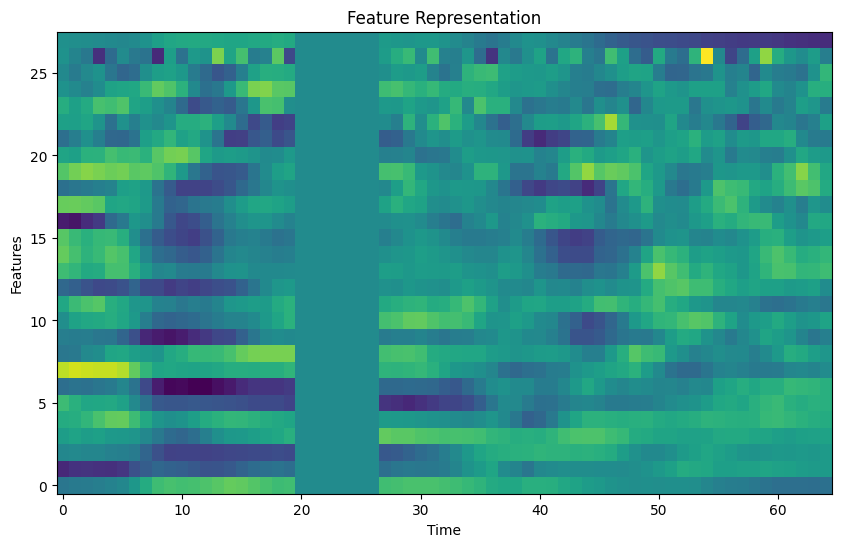

In [15]:
import matplotlib.pyplot as plt

# Testing code to check if your data loaders are working
for i, data in enumerate(train_loader):
    frames, phoneme = data
    print(frames.shape, phoneme.shape)

    # Visualize sample mfcc to inspect and verify everything is correctly done, especially augmentations
    plt.figure(figsize=(10, 6))
    plt.imshow(frames[0].numpy().T, aspect='auto', origin='lower', cmap='viridis')
    plt.xlabel('Time')
    plt.ylabel('Features')
    plt.title('Feature Representation')
    plt.show()

    break

In [16]:
# Testing code to check if your validation data loaders are working
all = []
for i, data in enumerate(val_loader):
    frames, phoneme = data
    all.append(phoneme)
    break

# Network Architecture


This section defines your network architecture for the homework. We have given you a sample architecture that can easily clear the very low cutoff for the early submission deadline.

In [20]:
# This architecture will make you cross the very low cutoff
# However, you need to run a lot of experiments to cross the medium or high cutoff

class Network(nn.Module):
    def __init__(self, input_size, output_size):
        super(Network, self).__init__()

        self.model = nn.Sequential(
            torch.nn.Linear(input_size, 2048),
            torch.nn.ReLU(),

            torch.nn.Linear(2048, 2048),
            torch.nn.ReLU(),

            torch.nn.Linear(2048, 2048),
            torch.nn.ReLU(),

            torch.nn.Linear(2048, 512),
            torch.nn.ReLU(),

            torch.nn.Linear(512, output_size)
        )

        if config['weight_initialization'] is not None:
            self.initialize_weights()

    def initialize_weights(self):
        for m in self.modules():
            if isinstance(m, torch.nn.Linear):
                if config["weight_initialization"] == "xavier_normal":
                    torch.nn.init.xavier_normal_(m.weight)
                elif config["weight_initialization"] == "xavier_uniform":
                    torch.nn.init.xavier_uniform_(m.weight)
                elif config["weight_initialization"] == "kaiming_normal":
                    torch.nn.init.kaiming_normal_(m.weight, nonlinearity='relu')
                elif config["weight_initialization"] == "kaiming_uniform":
                    torch.nn.init.kaiming_uniform_(m.weight, nonlinearity='relu')
                elif config["weight_initialization"] == "uniform":
                    torch.nn.init.uniform_(m.weight)
                else:
                    raise ValueError("Invalid weight_initialization value")

                # Initialize bias to 0
                m.bias.data.fill_(0)


    def forward(self, x):

        # Flatten to a 1D vector for each data point
        x = torch.flatten(x, start_dim=1)  # Keeps batch size, flattens the rest

        return self.model(x)

In [17]:
class ResidualMLPBlock(nn.Module):
    def __init__(self, dim, bottleneck, dropout):
        super().__init__()

        self.fc1 = nn.Linear(dim, bottleneck)
        self.fc2 = nn.Linear(bottleneck, dim)

        self.norm1 = nn.LayerNorm(bottleneck)
        self.norm2 = nn.LayerNorm(dim)

        self.dropout = nn.Dropout(dropout)

    def forward(self, x):
        identity = x

        # Project to bottleneck
        x = self.fc1(x)
        x = self.norm1(x)
        x = F.gelu(x)

        # Project back
        x = self.fc2(x)
        x = self.norm2(x)

        x = x + identity
        return self.dropout(F.gelu(x))



class Network(nn.Module):
    def __init__(self, input_size, output_size, dropout_rate=0.1):
        super().__init__()

        hidden = 1536
        bottleneck = 640
        num_blocks = 6  

        # Input projection
        self.fc_in = nn.Linear(input_size, hidden)
        self.norm_in = nn.LayerNorm(hidden)

        # Residual trunk
        self.blocks = nn.Sequential(
            *[ResidualMLPBlock(hidden, bottleneck, dropout_rate) 
              for _ in range(num_blocks)]
        )

        # Deep head
        self.head = nn.Sequential(
            nn.Linear(hidden, 1024),
            nn.GELU(),
            nn.LayerNorm(1024),

            nn.Linear(1024, 512),
            nn.GELU(),
            nn.LayerNorm(512),

            nn.Linear(512, output_size)
        )

        if config.get("weight_initialization", None) is not None:
            self.initialize_weights()

    def initialize_weights(self):
        for m in self.modules():
            if isinstance(m, nn.Linear):
                if config["weight_initialization"] == "xavier_normal":
                    nn.init.xavier_normal_(m.weight)
                elif config["weight_initialization"] == "xavier_uniform":
                    nn.init.xavier_uniform_(m.weight)
                elif config["weight_initialization"] == "kaiming_normal":
                    nn.init.kaiming_normal_(m.weight, nonlinearity="relu")
                elif config["weight_initialization"] == "kaiming_uniform":
                    nn.init.kaiming_uniform_(m.weight, nonlinearity="relu")
                elif config["weight_initialization"] == "uniform":
                    nn.init.uniform_(m.weight)
                else:
                    raise ValueError("Invalid weight_initialization value")
                m.bias.data.zero_()

    def forward(self, x):
        x = torch.flatten(x, start_dim=1)

        x = self.fc_in(x)
        x = self.norm_in(x)
        x = F.gelu(x)

        x = self.blocks(x)
        return self.head(x)


# Define Model, Loss Function and Optimizer

Here we define the model, loss function, optimizer and optionally a learning rate scheduler.

In [18]:
# Define the input size
INPUT_SIZE  = (2*config['context'] + 1) * 28 # Why is this the case?

# Instantiate model and load to GPU
model       = Network(INPUT_SIZE, len(train_data.phonemes)).to(device).cuda()

# Remember, you are limited to 20 million parameters for HW1 (including ensembles)
# Check to stay below 20 MIL Parameter limit
assert sum(p.numel() for p in model.parameters() if p.requires_grad) < 20_000_000, "Exceeds 20 MIL params. Any submission made to Kaggle with this model will be flagged as an AIV."

In [19]:
# Inspect model architecture and check to verify number of parameters of your network
try:
    # Install and import torchsummaryX
    !pip install torchsummaryX==1.1.0
    from torchsummaryX import summary

    summary(model, frames.to(device))

except:
    !pip install torchsummary
    from torchsummary import summary

    summary(model, frames[0].to(device).shape)

----------------------------------------------------------------------------------------------------
Layer                   Kernel Shape         Output Shape         # Params (K)      # Mult-Adds (M)
0_Linear                [1820, 1536]         [2048, 1536]             2,797.06                 2.80
1_LayerNorm                   [1536]         [2048, 1536]                 3.07                 0.00
2_Linear                 [1536, 640]          [2048, 640]               983.68                 0.98
3_LayerNorm                    [640]          [2048, 640]                 1.28                 0.00
4_Linear                 [640, 1536]         [2048, 1536]               984.58                 0.98
5_LayerNorm                   [1536]         [2048, 1536]                 3.07                 0.00
6_Dropout                          -         [2048, 1536]                    -                    -
7_Linear                 [1536, 640]          [2048, 640]               983.68                 0.98

# Define Model, Loss Function and Optimizer

Here we define the model, loss function, optimizer and optionally a learning rate scheduler.

In [20]:
#criterion = torch.nn.CrossEntropyLoss() # Defining Loss function.
# We use CE because the task is multi-class classification
class ConservativeSmartLoss(nn.Module):
    def __init__(self, num_classes):
        super().__init__()
        self.num_classes = num_classes
        self.smoothing = 0.1  # Fixed, reasonable value
        
    def forward(self, logits, targets):
        # Simple label smoothing - no adaptive complications
        if self.smoothing > 0:
            smooth_targets = torch.zeros_like(logits).scatter_(
                1, targets.unsqueeze(1), 1.0 - self.smoothing)
            smooth_targets += self.smoothing / max(1, self.num_classes - 1)
            
            log_probs = F.log_softmax(logits, dim=-1)
            loss = -torch.sum(smooth_targets * log_probs, dim=-1)
        else:
            loss = F.cross_entropy(logits, targets, reduction='none')
        
        return loss.mean()

criterion = ConservativeSmartLoss(num_classes=len(train_data.phonemes)).to(device)


# Choose an appropriate optimizer of your choice
optimizer = torch.optim.AdamW(model.parameters(), lr=config['learning_rate'])

# Recommended : Define Scheduler for Learning Rate,
# including but not limited to StepLR, MultiStep, CosineAnnealing, CosineAnnealingWithWarmRestarts, ReduceLROnPlateau, etc.
# You can refer to Pytorch documentation for more information on how to use them.
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(
    optimizer,
    T_max=config['epochs'],
    eta_min=1e-6
)

# Is your training time very high?
# Look into mixed precision training if your GPU (Tesla T4, V100, etc) can make use of it
# Refer - https://pytorch.org/docs/stable/notes/amp_examples.html
# Mixed Precision Training with AMP for speedup
scaler = torch.amp.GradScaler('cuda', enabled=True)

# Training and Validation Functions

This section covers the training, and validation functions for each epoch of running your experiment with a given model architecture. The code has been provided to you, but we recommend going through the comments to understand the workflow to enable you to write these loops for future HWs.

In [21]:
# CLEAR RAM!!
torch.cuda.empty_cache()
gc.collect()

10985

In [22]:
def train(model, dataloader, optimizer, criterion):

    model.train()
    tloss, tacc = 0, 0 # Monitoring loss and accuracy
    batch_bar   = tqdm(total=len(train_loader), dynamic_ncols=True, leave=False, position=0, desc='Train')

    for i, (frames, phonemes) in enumerate(dataloader):

        ### Initialize Gradients
        optimizer.zero_grad()

        frames      = frames.to(device)
        phonemes    = phonemes.to(device)

        with torch.autocast(device_type=device, dtype=torch.float16):
            ### Forward Propagation
            logits  = model(frames)

            ### Loss Calculation
            loss    = criterion(logits, phonemes)

        ### Backward Propagation
        scaler.scale(loss).backward()

        # OPTIONAL: You can add gradient clipping here, if you face issues of exploding gradients

        ### Gradient Descent
        scaler.step(optimizer)
        scaler.update()

        tloss   += loss.item()
        tacc    += torch.sum(torch.argmax(logits, dim= 1) == phonemes).item()/logits.shape[0]

        batch_bar.set_postfix(loss="{:.04f}".format(float(tloss / (i + 1))),
                              acc="{:.04f}%".format(float(tacc*100 / (i + 1))))
        batch_bar.update()

        ### Release memory
        del frames, phonemes, logits
        torch.cuda.empty_cache()


    batch_bar.close()
    tloss   /= len(train_loader)
    tacc    /= len(train_loader)


    return tloss, tacc

In [23]:
# Combine train and val datasets for cross-validation
combined_data = ConcatDataset([train_data, val_data])
print(f"Combined dataset size: {len(combined_data)} samples")

Combined dataset size: 38019361 samples


In [24]:
# Define the input size
INPUT_SIZE = (2*config['context'] + 1) * 28

In [25]:
def train_with_cv(combined_data, num_folds=3, use_wandb=True):
    """
    Perform k-fold cross-validation on combined dataset
    """
    total_samples = len(combined_data)
    indices = np.arange(total_samples)
    np.random.shuffle(indices)
    
    fold_size = total_samples // num_folds
    fold_results = []
    fold_models = []
    
    print(f"\n{'='*60}")
    print(f"Starting {num_folds}-Fold Cross-Validation")
    print(f"Total samples: {total_samples}, Fold size: ~{fold_size}")
    print(f"{'='*60}")
    
    for fold in range(num_folds):
        print(f"\n{'='*60}")
        print(f"Training Fold {fold + 1}/{num_folds}")
        print(f"{'='*60}")
        
        # Create validation indices for this fold
        val_start = fold * fold_size
        val_end = (fold + 1) * fold_size if fold < num_folds - 1 else total_samples
        val_indices = indices[val_start:val_end]
        train_indices = np.concatenate([indices[:val_start], indices[val_end:]])
        
        print(f"Train samples: {len(train_indices)}, Val samples: {len(val_indices)}")
        
        # Create subset datasets
        train_subset = Subset(combined_data, train_indices)
        val_subset = Subset(combined_data, val_indices)
        
        # Create dataloaders for this fold
        # Note: We need to use the collate_fn from the original dataset
        train_loader = torch.utils.data.DataLoader(
            dataset=train_subset,
            num_workers=4,
            batch_size=config['batch_size'],
            pin_memory=True,
            shuffle=True,
            collate_fn=train_data.collate_fn  # Use original train_data's collate_fn
        )
        
        val_loader = torch.utils.data.DataLoader(
            dataset=val_subset,
            num_workers=0,
            batch_size=config['batch_size'],
            pin_memory=True,
            shuffle=False,
            collate_fn=train_data.collate_fn  # Use original train_data's collate_fn
        )
        
        # Initialize fresh model for this fold
        torch.cuda.empty_cache()
        gc.collect()
        
        model = Network(INPUT_SIZE, len(train_data.phonemes)).to(device)
        
        # Check parameter count
        total_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
        print(f"Model parameters: {total_params:,}")
        assert total_params < 20_000_000, "Exceeds 20 MIL params!"
        
        # Initialize optimizer and scheduler
        optimizer = torch.optim.AdamW(model.parameters(), lr=config['learning_rate'])
        
        # Using Cosine Annealing for better convergence
        scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(
                    optimizer,
                    T_max=config['epochs'],
                    eta_min=1e-6
                )
        
        # Initialize gradient scaler for mixed precision
        scaler = torch.cuda.amp.GradScaler()
        
        # Training loop for this fold
        best_val_acc = 0
        best_epoch = 0
        patience_counter = 0
        early_stop_patience = config.get('early_stop_patience', 10)
        
        for epoch in range(config['epochs']):
            print(f"\nFold {fold+1} - Epoch {epoch+1}/{config['epochs']}")
            
            # Train
            model.train()
            train_loss, train_acc = 0, 0
            batch_bar = tqdm(total=len(train_loader), dynamic_ncols=True, leave=False, position=0, desc='Train')
            
            for i, (frames, phonemes) in enumerate(train_loader):
                optimizer.zero_grad()
                frames = frames.to(device)
                phonemes = phonemes.to(device)
                
                with torch.autocast(device_type=device, dtype=torch.float16):
                    logits = model(frames)
                    loss = criterion(logits, phonemes)
                
                scaler.scale(loss).backward()
                scaler.step(optimizer)
                scaler.update()
                
                train_loss += loss.item()
                train_acc += torch.sum(torch.argmax(logits, dim=1) == phonemes).item() / len(phonemes)
                
                batch_bar.set_postfix(
                    loss=f"{float(train_loss / (i + 1)):.04f}",
                    acc=f"{float(train_acc * 100 / (i + 1)):.02f}%"
                )
                batch_bar.update()
                
                del frames, phonemes, logits
                torch.cuda.empty_cache()
            
            batch_bar.close()
            train_loss /= len(train_loader)
            train_acc /= len(train_loader)
            
            # Validate
            model.eval()
            val_loss, val_acc = 0, 0
            batch_bar = tqdm(total=len(val_loader), dynamic_ncols=True, leave=False, position=0, desc='Val')
            
            with torch.inference_mode():
                for i, (frames, phonemes) in enumerate(val_loader):
                    frames = frames.to(device)
                    phonemes = phonemes.to(device)
                    
                    logits = model(frames)
                    loss = criterion(logits, phonemes)
                    
                    val_loss += loss.item()
                    val_acc += torch.sum(torch.argmax(logits, dim=1) == phonemes).item() / len(phonemes)
                    
                    batch_bar.set_postfix(
                        loss=f"{float(val_loss / (i + 1)):.04f}",
                        acc=f"{float(val_acc * 100 / (i + 1)):.02f}%"
                    )
                    batch_bar.update()
                    
                    del frames, phonemes, logits
                    torch.cuda.empty_cache()
            
            batch_bar.close()
            val_loss /= len(val_loader)
            val_acc /= len(val_loader)
            
            # Log metrics
            curr_lr = float(optimizer.param_groups[0]['lr'])
            print(f"\tTrain Acc: {train_acc*100:.2f}%, Loss: {train_loss:.4f}")
            print(f"\tVal Acc: {val_acc*100:.2f}%, Loss: {val_loss:.4f}, LR: {curr_lr:.7f}")
            
            if use_wandb:
                wandb.log({
                    f'fold_{fold}_train_acc': train_acc * 100,
                    f'fold_{fold}_train_loss': train_loss,
                    f'fold_{fold}_val_acc': val_acc * 100,
                    f'fold_{fold}_val_loss': val_loss,
                    f'fold_{fold}_lr': curr_lr,
                    'epoch': epoch
                })
            
            # Save best model for this fold
            if val_acc > best_val_acc:
                best_val_acc = val_acc
                best_epoch = epoch
                patience_counter = 0
                
                # Save model checkpoint
                checkpoint = {
                    'fold': fold,
                    'epoch': epoch,
                    'model_state_dict': model.state_dict(),
                    'optimizer_state_dict': optimizer.state_dict(),
                    'val_acc': val_acc,
                    'train_acc': train_acc,
                    'config': config
                }
                torch.save(checkpoint, f'fold_{fold}_best_model.pth')
                print(f"\t✓ New best model saved! Val Acc: {val_acc*100:.2f}%")
            else:
                patience_counter += 1
                if patience_counter >= early_stop_patience:
                    print(f"\t⚠ Early stopping triggered after {patience_counter} epochs without improvement")
                    break
            
            # Step scheduler
            scheduler.step()
        
        # Store fold results
        fold_results.append(best_val_acc)
        fold_models.append(model)  # Store the trained model
        
        print(f"\nFold {fold+1} completed. Best Val Acc: {best_val_acc*100:.2f}% at epoch {best_epoch+1}")
        
        # Clean up for next fold
        del model, optimizer, scheduler, scaler
        torch.cuda.empty_cache()
        gc.collect()
    
    # Print cross-validation summary
    print(f"\n{'='*60}")
    print(f"{num_folds}-Fold Cross-Validation Results:")
    print(f"{'='*60}")
    fold_accs = [acc * 100 for acc in fold_results]
    for i, acc in enumerate(fold_accs):
        print(f"Fold {i+1}: {acc:.2f}%")
    
    print(f"\nMean CV Accuracy: {np.mean(fold_accs):.2f}%")
    print(f"Std CV Accuracy: {np.std(fold_accs):.2f}%")
    print(f"Min CV Accuracy: {np.min(fold_accs):.2f}%")
    print(f"Max CV Accuracy: {np.max(fold_accs):.2f}%")
    
    return fold_results, fold_models

In [26]:
def eval(model, dataloader):

    model.eval() # set model in evaluation mode
    vloss, vacc = 0, 0 # Monitoring loss and accuracy
    batch_bar   = tqdm(total=len(val_loader), dynamic_ncols=True, position=0, leave=False, desc='Val')

    for i, (frames, phonemes) in enumerate(dataloader):

        ### Move data to device (ideally GPU)
        frames      = frames.to(device)
        phonemes    = phonemes.to(device)

        # makes sure that there are no gradients computed as we are not training the model now
        with torch.inference_mode():
            ### Forward Propagation
            logits  = model(frames)
            ### Loss Calculation
            loss    = criterion(logits, phonemes)

        vloss   += loss.item()
        vacc    += torch.sum(torch.argmax(logits, dim= 1) == phonemes).item()/logits.shape[0]

        # Do you think we need loss.backward() and optimizer.step() here?

        batch_bar.set_postfix(loss="{:.04f}".format(float(vloss / (i + 1))),
                              acc="{:.04f}%".format(float(vacc*100 / (i + 1))))
        batch_bar.update()

        ### Release memory
        del frames, phonemes, logits
        torch.cuda.empty_cache()

    batch_bar.close()
    vloss   /= len(val_loader)
    vacc    /= len(val_loader)

    return vloss, vacc

# Weights and Biases Setup

This section is to enable logging metrics and files with Weights and Biases. Please refer to wandb documentationa and recitation 0 that covers the use of weights and biases for logging, hyperparameter tuning and monitoring your runs for your homeworks. Using this tool makes it very easy to show results when submitting your code and models for homeworks, and also extremely useful for study groups to organize and run ablations under a single team in wandb.

We have written code for you to make use of it out of the box, so that you start using wandb for all your HWs from the beginning.

In [27]:
wandb.login(key="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") #API Key is in your wandb account, under settings (wandb.ai/settings)

/usr/local/lib/python3.12/dist-packages/notebook/notebookapp.py:191: SyntaxWarning: invalid escape sequence '\/'
  | |_| | '_ \/ _` / _` |  _/ -_)
wandb: WARNING If you're specifying your api key in code, ensure this code is not shared publicly.
wandb: WARNING Consider setting the WANDB_API_KEY environment variable, or running `wandb login` from the command line.
wandb: [wandb.login()] Using explicit session credentials for https://api.wandb.ai.
wandb: No netrc file found, creating one.
wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc
wandb: Currently logged in as: nyatuka2407 (nyatuka2407-multimdia-university-of-kenya) to https://api.wandb.ai. Use `wandb login --relogin` to force relogin


True

In [28]:
# Create your wandb run
RESUME_OLD_RUN = False

if RESUME_OLD_RUN == True:
    print("Resuming previous WanDB run...")
    run = wandb.init(
        name    = "first-run1", ### Wandb creates random run names if you skip this field, we recommend you give useful names
        id     = "", ### Insert specific run id here if you want to resume a previous run
        resume = "must", ### You need this to resume previous runs, but comment out reinit = True when using this
        project = "hw1p2", ### Project should be created in your wandb account
        config  = config ### Wandb Config for your run
    )
else:
    print("Initializing new WanDB run...")
    run = wandb.init(
        name    = "first-run1", ### Wandb creates random run names if you skip this field, we recommend you give useful names
        reinit  = True, ### Allows reinitalizing runs when you re-run this cell
        project = "hw1p2", ### Project should be created in your wandb account
        config  = config ### Wandb Config for your run
    )

Initializing new WanDB run...


wandb: WARNING Using a boolean value for 'reinit' is deprecated. Use 'return_previous' or 'finish_previous' instead.


In [29]:
### Save your model architecture as a string with str(model)
model_arch  = str(model)

### Save it in a txt file
arch_file   = open("model_arch.txt", "w")
file_write  = arch_file.write(model_arch)
arch_file.close()

### log it in your wandb run with wandb.save()
wandb.save('model_arch.txt')

wandb: WARNING Symlinked 1 file into the W&B run directory; call wandb.save again to sync new files.


['/kaggle/working/wandb/run-20260202_072218-mpyne0j5/files/model_arch.txt']

# Experiment

Now, it is time to finally run your ablations! Have fun!

In [34]:
'''
# Iterate over number of epochs to train and evaluate your model
torch.cuda.empty_cache()
gc.collect()
#wandb.watch(model, log="all")

for epoch in range(config['epochs']):

    print("\nEpoch {}/{}".format(epoch+1, config['epochs']))

    curr_lr                 = float(optimizer.param_groups[0]['lr'])
    train_loss, train_acc   = train(model, train_loader, optimizer, criterion)
    val_loss, val_acc       = eval(model, val_loader)

    print("\tTrain Acc {:.04f}%\tTrain Loss {:.04f}\t Learning Rate {:.07f}".format(train_acc*100, train_loss, curr_lr))
    print("\tVal Acc {:.04f}%\tVal Loss {:.04f}".format(val_acc*100, val_loss))

    ## Log metrics at each epoch in your run
    # Optionally, you can log at each batch inside train/eval functions
    # (explore wandb documentation/wandb recitation)
    wandb.log({'train_acc': train_acc*100, 'train_loss': train_loss,
               'val_acc': val_acc*100, 'valid_loss': val_loss, 'lr': curr_lr})

    # If using a scheduler, step the learning rate here, otherwise comment this line
    # Depending on the scheduler in use, you may or may not need to pass in a metric into the step function, so read the docs well
    scheduler.step(val_acc)

    ## HIGHLY RECOMMENDED: Save model checkpoint in drive and/or wandb if accuracy is better than your current best accuracy
    ## This enables you to resume training at anytime, without having to start from scratch.
    ## Refer to Recitation 0.24 to learn how to implement this: https://www.youtube.com/watch?v=-TCH0DbUEKM&list=PLp-0K3kfddPw2D5CeA09lsx_oNy9E
    
'''

'\n# Iterate over number of epochs to train and evaluate your model\ntorch.cuda.empty_cache()\ngc.collect()\n#wandb.watch(model, log="all")\n\nfor epoch in range(config[\'epochs\']):\n\n    print("\nEpoch {}/{}".format(epoch+1, config[\'epochs\']))\n\n    curr_lr                 = float(optimizer.param_groups[0][\'lr\'])\n    train_loss, train_acc   = train(model, train_loader, optimizer, criterion)\n    val_loss, val_acc       = eval(model, val_loader)\n\n    print("\tTrain Acc {:.04f}%\tTrain Loss {:.04f}\t Learning Rate {:.07f}".format(train_acc*100, train_loss, curr_lr))\n    print("\tVal Acc {:.04f}%\tVal Loss {:.04f}".format(val_acc*100, val_loss))\n\n    ## Log metrics at each epoch in your run\n    # Optionally, you can log at each batch inside train/eval functions\n    # (explore wandb documentation/wandb recitation)\n    wandb.log({\'train_acc\': train_acc*100, \'train_loss\': train_loss,\n               \'val_acc\': val_acc*100, \'valid_loss\': val_loss, \'lr\': curr_lr})\n\

In [ ]:
# Run cross-validation
fold_results, fold_models = train_with_cv(
    combined_data,
    use_wandb=True
)


Starting 3-Fold Cross-Validation
Total samples: 38019361, Fold size: ~12673120

Training Fold 1/3
Train samples: 25346241, Val samples: 12673120
Model parameters: 16,759,082

Fold 1 - Epoch 1/25


/tmp/ipykernel_55/3281246084.py:77: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = torch.cuda.amp.GradScaler()


Train:   0%|          | 0/12377 [00:00<?, ?it/s]

Val:   0%|          | 0/6189 [00:00<?, ?it/s]

	Train Acc: 70.34%, Loss: 1.4859
	Val Acc: 76.90%, Loss: 1.2889, LR: 0.0005000
	✓ New best model saved! Val Acc: 76.90%

Fold 1 - Epoch 2/25


Train:   0%|          | 0/12377 [00:00<?, ?it/s]

In [31]:

# Initialize empty list for fold models
fold_models = []

# List of your saved model files
saved_model_files = [
    '/kaggle/input/best-run/fold_0_best_model.pth',
    '/kaggle/input/best-run/fold_1_best_model.pth', 
]

print("Loading saved fold models...")
print("-" * 50)

# Load each model file
for i, model_file in enumerate(saved_model_files):
    try:
        # Load the checkpoint
        checkpoint = torch.load(model_file, map_location='cpu')
        
        # Create a new model instance with the same architecture
        model = Network(INPUT_SIZE, len(train_data.phonemes))
        
        # Check what's in the checkpoint
        print(f"\n{model_file} contains:")
        for key in checkpoint.keys():
            print(f"  - {key}: {type(checkpoint[key]).__name__}")
        
        # Load the model weights
        if 'model_state_dict' in checkpoint:
            model.load_state_dict(checkpoint['model_state_dict'])
            print(f"✓ Loaded model weights from 'model_state_dict'")
            if 'val_acc' in checkpoint:
                print(f"  Validation accuracy: {checkpoint['val_acc']*100:.2f}%")
        else:
            # If the checkpoint is just the model state dict directly
            model.load_state_dict(checkpoint)
            print(f"✓ Loaded model weights (direct state dict)")
        
        # Move model to GPU if available
        model = model.to(device)
        
        # Set model to evaluation mode
        model.eval()
        
        # Add to fold_models list
        fold_models.append(model)
        
        print(f"✓ Successfully loaded {model_file} as fold_models[{i}]")
        
    except FileNotFoundError:
        print(f"✗ ERROR: {model_file} not found!")
        print("Make sure the file is in your current working directory.")
    except Exception as e:
        print(f"✗ ERROR loading {model_file}: {str(e)}")
        print("Check if the model architecture matches your Network class.")

print("\n" + "=" * 50)
print(f"Successfully loaded {len(fold_models)} models into fold_models")
print("=" * 50)

Loading saved fold models...
--------------------------------------------------

/kaggle/input/best-run/fold_0_best_model.pth contains:
  - fold: int
  - epoch: int
  - model_state_dict: OrderedDict
  - optimizer_state_dict: dict
  - val_acc: float
  - train_acc: float
  - config: dict
✓ Loaded model weights from 'model_state_dict'
  Validation accuracy: 88.77%
✓ Successfully loaded /kaggle/input/best-run/fold_0_best_model.pth as fold_models[0]

/kaggle/input/best-run/fold_1_best_model.pth contains:
  - fold: int
  - epoch: int
  - model_state_dict: OrderedDict
  - optimizer_state_dict: dict
  - val_acc: float
  - train_acc: float
  - config: dict
✓ Loaded model weights from 'model_state_dict'
  Validation accuracy: 88.75%
✓ Successfully loaded /kaggle/input/best-run/fold_1_best_model.pth as fold_models[1]

Successfully loaded 2 models into fold_models


# Testing and submission to Kaggle

Before we get to the following code, make sure to see the format of submission given in *sample_submission.csv*. Once you have done so, it is time to fill the following function to complete your inference on test data. Refer the eval function from previous cells to get an idea of how to go about completing this function.

In [32]:
phoneme2idx = {p: i for i, p in enumerate(PHONEMES)}
idx2phoneme = {i: p for i, p in enumerate(PHONEMES)}

In [33]:
def test(model, test_loader):
    ### What you call for model to perform inference?
    model.eval() # TODO train or eval?

    ### List to store predicted phonemes of test data
    test_predictions = []

    ### Which mode do you need to avoid gradients?
    with torch.no_grad(): # TODO

        for i, mfccs in enumerate(tqdm(test_loader)):

            mfccs   = mfccs.to(device)

            logits  = model(mfccs)

            ### Get most likely predicted phoneme with argmax
            predicted_phonemes = torch.argmax(logits, dim=1)
            predicted_phonemes = predicted_phonemes.cpu().tolist()

            ### How do you store predicted_phonemes with test_predictions? HINT: look at the eval() function from earlier
            # Remember the phonemes were converted from strings to their corresponding integer indices earlier, and the results of the argmax is a list of the integer indices of the predicted phonemes.
            # So how do you get and store the actual predicted phonemes (strings NOT integers)
            # TODO: Convert predicted_phonemes (integer indices from argmax) back to phoneme strings and append them to test_predictions
            for idx in predicted_phonemes:
                phoneme_str = idx2phoneme[idx]
                test_predictions.append(phoneme_str)

    ## SANITY CHECK
    sample_predictions = test_predictions[:10]
    if not isinstance(sample_predictions[0], str):
        print(f"❌ ERROR: Predictions should be phoneme STRINGS, not {type(sample_predictions[0]).__name__}!")
        print(f"   You need to convert integer indices to their corresponding phoneme strings")
        print(f"   Hint: Look at the eval() function to get the idea")

    # Print a preview of predictions for manual inspection
    print("\nSample predictions:", sample_predictions)
    print("\nPredictions Generated successfully!")

    return test_predictions

In [34]:
def create_ensemble_predictions(fold_models, test_dataset):
    print("\nGenerating ensemble predictions (mean-logits)...")

    ensemble_predictions = []

    with torch.no_grad():
        for seq_idx in tqdm(range(len(test_dataset))):
            frames = test_dataset[seq_idx]   # (T, 41, 28)

            for t in range(frames.shape[0]):
                input_vector = frames[t].reshape(1, -1).to(device)  # (1, 1148)

                logits_list = []
                for model in fold_models:
                    logits = model(input_vector)
                    logits_list.append(logits)

                avg_logits = torch.mean(torch.stack(logits_list), dim=0)
                pred_idx = torch.argmax(avg_logits, dim=1).item()
                ensemble_predictions.append(pred_idx)

    ensemble_predictions = [idx2phoneme[idx] for idx in ensemble_predictions]
    return ensemble_predictions


In [ ]:
# Generate model test predictions

#predictions = test(model, test_loader)

In [35]:
#predictions = create_ensemble_predictions(fold_models, test_loader)

predictions = create_ensemble_predictions(fold_models, test_data)


Generating ensemble predictions (mean-logits)...


  0%|          | 0/2620 [00:00<?, ?it/s]

In [36]:
### Create CSV file with predictions

with open("./submission.csv", "w+") as f:
    f.write("id,label\n")
    for i in range(len(predictions)):
        f.write("{},{}\n".format(i, predictions[i]))

    print("submission.csv file created successfully!")

submission.csv file created successfully!


In [37]:
### Finish your wandb run
run.finish()

# Submit to kaggle competition using kaggle API

In [38]:
if "KAGGLE_KERNEL_RUN_TYPE" in os.environ:
    # If on kaggle:
    !kaggle competitions submit -c hw-1-p-2-spring-2026-student-competition -f submission.csv -m "Test Submission"
else:
    # If NOT on kaggle:
    # Adjust path of '/content/submission.csv' if necessary
    !kaggle competitions submit -c hw-1-p-2-spring-2026-student-competition -f /content/submission.csv -m "Test Submission"

### If this fails, you can download the csv file and then submit directly on the kaggle competition page

100%|██████████████████████████████████████| 19.3M/19.3M [00:00<00:00, 32.2MB/s]
Successfully submitted to HW1P2_Spring_2026_Student_Competition

## TODO: DO NOT MODIFY, RUN AS IS
#### Generate a model_metadata.json file to save your model's data (due 48 hours after Kaggle submission deadline OR the day of slack submission)

In [ ]:
import json, os, sys, torch, zipfile, datetime
################################
# TODO: Keep the model_metadata.json
# file safe for submission later.
################################
def generate_model_submission_file():
    timestamp = datetime.datetime.now().strftime("%Y-%m-%d_%H-%M")
    json_filename = f"model_metadata_{timestamp}.json"

    # Create JSON with parameter count, model architecture, and predictions
    output_json = {
        "parameter_count": sum(p.numel() for p in model.parameters() if p.requires_grad),
        "model_architecture": str(model),
    }

    # Save metadata JSON
    with open(json_filename, "w") as f:
        json.dump(output_json, f, indent=2)

    # Download / display link depending on environment
    if "google.colab" in sys.modules and "COLAB_GPU" in os.environ:
        from google.colab import files
        files.download(json_filename)
    elif "KAGGLE_KERNEL_RUN_TYPE" in os.environ:
        from IPython.display import FileLink, display
        print("#" * 100)
        print(f"Your submission file `{json_filename}` has been generated.")
        print("TODO: Click the link below.")
        print("1. The file will open in a new tab.")
        print("2. Right-click anywhere in the new tab and select 'Save As...'")
        print("3. Save the file to your computer with the `.json` extension.")
        print("You MUST submit this file to Autolab if this is your best submission.")
        print("#" * 100 + "\n")
        display(FileLink(json_filename))
    else:
        print(f"✅ saved model data saved to: '{json_filename}'")
        print("REQUIRED to submit to Autolab if these are the best model weights.")

generate_model_submission_file()

# Final Code Submission Section

In [ ]:
####################################
#             README
####################################

# TODO: Please complete all components of this README
README = """
- **Model**: Model archtiecture description. Anything unique? Any specific architecture shapes or strategies?
- **Training Strategy**: optimizer + scheduler + loss function + any other unique ideas
- **Augmentations**: augmentations if used. If augmentations weren't used, then ignore
- **Notebook Execution**: Any instructions required to run your notebook.
"""

####################################
#       Credentials (Optional)
####################################

# These are not required **IF** you have run the cells to declare these variables above.
# If you would like to paste your credentials here again, feel free to:
# OPTIONAL: Fill these out if you do not want to re-run previous cells to re-initialize these credential variables

if "KAGGLE_USERNAME" not in globals():
  KAGGLE_USERNAME = None # Optional: Put your kaggle username here

if "KAGGLE_API_KEY" not in globals():
  KAGGLE_API_KEY = None # Optional: Put your kaggle api key here

if "WANDB_API_KEY" not in globals():
  WANDB_API_KEY = None # Optional: Put your wandb api key here


####################################
#             Wandb Logs
####################################

# TODO: Your wandb project url should look like https://wandb.ai/username-or-team-name/project-name
#(Take these parameters and put them in the variables below)

WANDB_USERNAME_OR_TEAMNAME = "YOUR USER NAME" # TODO: Put your username-or-team-name here
WANDB_PROJECT = "hw1p2" # TODO: Put your project-name

####################################
#         Notebook & Files
####################################

# TODO: Download HW1P2 Notebook (if on colab or kaggle) and upload both your HW1P2 notebook + model_metadata_*.json to your file system.
# TODO: For each file, obtain the file paths and put them below.

# TODO: COLAB INSTRUCTIONS:
# * With Colab, upload your desired file (notebook or model_metadata.json) to "Files"
# * Right-click the file, click "Copy Path,"
# * Paste the path below.

# TODO: KAGGLE INSTRUCTIONS:
# * First download a copy of your notebook with "File > Download Notebook"
# Then...
# * Click "File" in the top left of the screen
# * Go to "Upload Input > Upload Model"
# * Upload your notebook file.
# * For "Model Name" put HW1P2_Final_Submission
# * For "Framework" put "Other"
# * For "License" put "Other"
# * Click "Upload another file" and upload your model_metadata####.json file as well.
# * Now, on your right in your "Models" section, you should see a new folder with your submission files.
# * Click on the "Copy File Path" buttons for the notebook and json file and paste them below.

# TODO: Linux system:
# * Simply upload or find the path of your notebook file and model_metadata###.json file, and paste them here.

NOTEBOOK_PATH = "/content/<YOUR_NOTEBOOK_PATH>.ipynb" # TODO: Put your HW1P2 notebook path here
MODEL_METADATA_JSON = "/content/<YOUR_METADATA_JSON_PATH>.json" # TODO: Put your Model Metadata path json file here (see end of HW1P2 Code Notebook to get this file)


####################################
#         Additional Files
####################################

ADDITIONAL_FILES = [ # TODO: Upload any files and add any paths to any additional files you would like to include in your submission, otherwise, leave this empty
]

####################################
#         SLACK SUBMISSION
####################################

ENABLE_SLACK_SUBMISSION = False # TODO: Set this to true if you are submitting to the Slack competition

####################################
#     Creating the Submission
####################################

# TODO: Once the README, wandb information, and file paths are filled in, run this cell,
# run the "Assignment Backend Functions" in the next cells, and generate the final zip file at the end.

SAFE_SUBMISSION = True # TODO: Set this to False if you want to generate a submission.zip even if you are missing files, otherwise it's recommended to keep this as True


# Assignment Backend Submission Functions (DO NOT MODIFY, just run these cells)

In [ ]:
from datetime import datetime

######################################
#       Assignment Configs
######################################

WANDB_METRIC = "val_acc"
WANDB_DIRECTION = "ascending"
WANDB_TOP_N = 10
WANDB_OUTPUT_PKL = "wandb_top_runs.pkl"

# Kaggle configuration
COMPETITION_NAME = "hw-1-p-2-spring-2026-student-competition"
SLACK_COMPETITION_NAME = "hw-1-p-2-spring-2026-student-slack-submission"
FINAL_SUBMISSION_DATETIME = datetime.strptime("2026-02-06 23:59:59", "%Y-%m-%d %H:%M:%S")
SLACK_SUBMISSION_DATETIME = datetime.strptime("2026-02-13 23:59:59", "%Y-%m-%d %H:%M:%S")
GRADING_DIRECTION = "ascending"
KAGGLE_OUTPUT_JSON = "kaggle_data.json"

SUBMISSION_OUTPUT = "HW1P2_final_submission.zip"


In [ ]:
def strict_wandb_extract(obj):
    """
    Robustly extracts data from WandB objects, handling strings,
    broken wrappers, and standard dicts.
    """
    # 1. If it's already a string, try to parse it as JSON.
    # If not JSON, return the string as-is.
    if isinstance(obj, str):
        try:
            return json.loads(obj)
        except (ValueError, TypeError):
            return obj

    # 2. Workaround for the library crash:
    # If it has the internal '_json_dict' attribute, use that directly
    # to bypass the broken .items() method.
    if hasattr(obj, '_json_dict'):
        return strict_wandb_extract(obj._json_dict)

    # 3. If it behaves like a normal dict, use .items()
    if hasattr(obj, 'items'):
        return dict(obj.items())

    # 4. Fallback: Return as is
    return obj

In [ ]:
ACKNOWLEDGEMENT_MESSAGE = """
Submission of this file and assignment indicate the student's agreement to the following Aknowledgement requirements:
Setting the ACNKOWLEDGED flag to True indicates full understanding and acceptance of the following:
1. Slack days may ONLY be used on P2 FINAL (not checkpoint) submission. I.e. you may use slack days to submit final P2 kaggle scores (such as this one) later on the **SLACK KAGGLE COMPETITION** at the expense of your Slack days.
2. The final autolab **code submission is due 48 hours after** the conclusion of the Kaggle Deadline (or, the same day as your final kaggle submission).
3. Course staff will require your kaggle username here, and then will pull your official PRIVATE kaggle leaderboard score. This submission may result in slight variance in scores/code, but we will check for acceptable discrepancies. Any discrepancies related to modifying the submission code (at the bottom of the notebook) will result in an AIV.
4. You are NOT allowed to use any code that will pre-load models (such as those from Hugging Face, etc.).
   You MAY use models described by papers or articles, but you MUST implement them yourself through fundamental PyTorch operations (i.e. Linear, Conv2d, etc.).
5. You are NOT allowed to use any external data/datasets at ANY point of this assignment.
6. You may work with teammates to run ablations/experiments, BUT you must submit your OWN code and your OWN results.
7. Failure to comply with the prior rules will be considered an Academic Integrity Violation (AIV).
8. Late submissions MUST be submitted through the Slack Kaggle (see writeup for details). Any submissions made to the regular Kaggle after the original deadline will NOT be considered, no matter how many slack days remain for the student.
"""
def save_acknowledgment_file():
    if ACKNOWLEDGED:
        with open("acknowledgement.txt", "w") as f:
            f.write(ACKNOWLEDGEMENT_MESSAGE.strip())
        print("Saved acknowledgement.txt")
        return True
    else:
        print("ERROR: Must set ACKNOWLEDGED = True.")
        return False
# Saves README
def save_readme(readme):
    try:
        with open("README.txt", "w") as f:
            f.write(readme.strip())

        print("Saved README.txt")
    except Exception as e:
        print(f"ERROR: Error occured while saving README.txt: {e}")
        return False

    return True
# Saves wandb logs
import wandb, json, pickle

def save_top_wandb_runs():
    wandb.login(key=WANDB_API_KEY)
    if not ACKNOWLEDGED:
        print("ERROR: Must set ACKNOWLEDGED = True.")
        return False

    api = wandb.Api()
    runs = api.runs(
        f"{WANDB_USERNAME_OR_TEAMNAME}/{WANDB_PROJECT}",
        order=f"{'-' if WANDB_DIRECTION == 'descending' else ''}summary_metrics.{WANDB_METRIC}"
    )
    selected_runs = runs[:min(WANDB_TOP_N, len(runs))]

    if not selected_runs:
        print(f"ERROR: No runs found for {WANDB_USERNAME_OR_TEAMNAME}/{WANDB_PROJECT}. Please check that your wandb credentials (Wandb Username/Team Name, API Key, and Project Name) are correct.")
        return False

    all_data = []
    for run in selected_runs:
        run_data = {
            "id": run.id,
            "name": run.name,
            "tags": run.tags,
            "state": run.state,
            "created_at": str(run.created_at),
            "config": json.loads(json.dumps(strict_wandb_extract(run.config), default=str)),
            "summary": json.loads(json.dumps(strict_wandb_extract(run.summary), default=str))
        }
        try:
            run_data["history"] = run.history(samples=1000)
        except Exception as e:
            run_data["history"] = f"Failed to fetch history: {str(e)}"
        all_data.append(run_data)
    with open(WANDB_OUTPUT_PKL, "wb") as f:
        pickle.dump(all_data, f)

    print(f"OK: Exported {len(all_data)} WandB runs to {WANDB_OUTPUT_PKL}")

    return True
# Saves kaggle information

# Install dependencies silently (only if running on Colab)
import sys

from datetime import datetime
import os, json, requests
def kaggle_login(username, key):
    os.makedirs(os.path.expanduser("~/.kaggle"), exist_ok=True)
    with open(os.path.expanduser("~/.kaggle/kaggle.json"), "w") as f:
        json.dump({"username": username, "key": key}, f)
    os.chmod(os.path.expanduser("~/.kaggle/kaggle.json"), 0o600)


def get_active_submission_config():
    if ENABLE_SLACK_SUBMISSION:
        return SLACK_COMPETITION_NAME, SLACK_SUBMISSION_DATETIME
    return COMPETITION_NAME, FINAL_SUBMISSION_DATETIME

def kaggle_user_exists(usernagbme):
    try:
        return requests.get(f"https://www.kaggle.com/{KAGGLE_USERNAME}").status_code == 200
    except Exception as e:
        print(f"ERROR: Error while checking Kaggle user: {e}")
        return False

DEFAULT_SCORE=0
if GRADING_DIRECTION == "ascending":
    DEFAULT_SCORE=0
else:
    DEFAULT_SCORE=1.0

def get_best_kaggle_score(subs):
    def extract_score(s):
        return float(
            (getattr(s, "private_score", None) or getattr(s, "privateScore", None)) or
            (getattr(s, "public_score", None)  or getattr(s, "publicScore", None))  or
            DEFAULT_SCORE
        )
    if not subs:
        return None, None
    best = max(subs, key=lambda s: extract_score(s) if GRADING_DIRECTION == "ascending" else -extract_score(s))
    score_type = "private" if (getattr(best, "private_score", None) or getattr(best, "privateScore", None)) not in [None, ""] else "public"
    return extract_score(best), score_type

def save_kaggle_json(kaggle_username, kaggle_key):

    kaggle_login(kaggle_username, kaggle_key)

    from kaggle.api.kaggle_api_extended import KaggleApi

    if not ACKNOWLEDGED:
        print("ERROR: Must set ACKNOWLEDGED = True.")
        return False

    if not kaggle_user_exists(KAGGLE_USERNAME):
        print(f"ERROR: User '{KAGGLE_USERNAME}' not found.")
        return False

    comp_name, deadline = get_active_submission_config()

    api = KaggleApi()
    api.authenticate()

    # Get competition submissions
    submissions = [s for s in api.competition_submissions(comp_name) if (getattr(s, "submitted_by", None) or getattr(s, "submittedBy", None)) == KAGGLE_USERNAME and getattr(s, "date") <= deadline]
    if not submissions:
        print(f"ERROR: No valid submissions found for user [{KAGGLE_USERNAME}] for this competition [{comp_name}]. Slack flag set to [{ENABLE_SLACK_SUBMISSION}]")
        print("Please double check your Kaggle username and ensure you've submitted at least once.")
        return False

    score, score_type = get_best_kaggle_score(submissions)
    result = {
        "kaggle_username": KAGGLE_USERNAME,
        "acknowledgement": ACKNOWLEDGED,
        "submitted_slack": ENABLE_SLACK_SUBMISSION,
        "competition_name": comp_name,
        "deadline": deadline.strftime("%Y-%m-%d %H:%M:%S"),
        "raw_score": score * 100.0,
        "score_type": score_type,
    }



    print(f"OK: Projected score (excluding bonuses) saved as {KAGGLE_OUTPUT_JSON}")
    if score:
        print(f"Best score {score}.")
        with open(KAGGLE_OUTPUT_JSON, "w") as f:
            json.dump(result, f, indent=2)
        return True
    return False


import os
import sys
import zipfile


def create_submission_zip(additional_files, safe_flag):
    if not "ACKNOWLEDGED" in globals() or not ACKNOWLEDGED:
        print("ERROR: Make sure to RUN the Acknowledgement cell (at the top of the notebook). Also, must set ACKNOWLEDGED = True.")
        return

    if (not save_acknowledgment_file()):
        print("ERROR: Make sure to RUN the Acknowledgement cell (at the top of the notebook). Also, must set ACKNOWLEDGED = True.")
        return

    if not "ENABLE_SLACK_SUBMISSION" in globals() or ENABLE_SLACK_SUBMISSION is None:
        print("ERROR: \"ENABLE_SLACK_SUBMISSION\" variable is not defined. \nTODO: Make sure to RUN the cell (A few cells up at the beginning of the submission section). \nMake sure to set the ENABLE_SLACK_SUBMISSION checkbox if you're on colab, or set the parameter correctly set on other platforms \n(if you are submitting through the SLACK submission).")
        return

    if not "README" in globals() or not README:
        print("ERROR: Make sure to RUN the README cell(above your credentials cell).")
        return

    if (not save_readme(README)):
        print("ERROR: Error while saving the README file. Make sure to complete and RUN the README cell(above your credentials cell).")
        return

    if (not save_top_wandb_runs()):
        return

    if not "KAGGLE_USERNAME" in globals() or not "KAGGLE_API_KEY" in globals() or not KAGGLE_USERNAME or not KAGGLE_API_KEY:
        print("ERROR: Make sure to set KAGGLE_USERNAME and KAGGLE_API_KEY for this code submission.")
        return

    if (not save_kaggle_json(KAGGLE_USERNAME, KAGGLE_API_KEY)):
        print(f"ERROR: An error occured while retrieve kaggle information from username [{KAGGLE_USERNAME}] from competition [{get_active_submission_config()[0]}] with slack flag set to [{ENABLE_SLACK_SUBMISSION}]. Please check your kaggle username, key, and submission.")
        return

    files_to_zip = [
        "acknowledgement.txt",
        "README.txt",
        KAGGLE_OUTPUT_JSON,
        WANDB_OUTPUT_PKL,
        MODEL_METADATA_JSON,
        NOTEBOOK_PATH,
    ] + additional_files

    custom_missing_files_messages = {
        KAGGLE_OUTPUT_JSON: "ERROR: Kaggle data retrieval was missing, please check your kaggle username, API Key, and that you have submitted to the correct competition."
    }

    missing_files = False

    with zipfile.ZipFile(SUBMISSION_OUTPUT, "w") as zipf:
        for file_path in files_to_zip:
            if os.path.exists(file_path):
                arcname = os.path.basename(file_path)  # flatten path
                zipf.write(file_path, arcname=arcname)
                print(f"OK: Added {arcname}")
            else:
                missing_files = True
                print(f"ERROR: Missing file: {file_path}")

    if missing_files:
        if safe_flag:
            print("ERROR: Missing files with safety flag set to True. Please upload any necessary files, ensure you have the correct paths and rerun all cells.")
            return
        else:
            print("WARNING: Missing files with safety flag set to False. Submission may be incomplete.")

    if "google.colab" in sys.modules and "COLAB_GPU" in os.environ:
        from google.colab import files
        files.download(SUBMISSION_OUTPUT)

    print("Final submission saved as:", SUBMISSION_OUTPUT)

# File Generation (TODO: Check file generation outputs for any errors)

In [ ]:
create_submission_zip(ADDITIONAL_FILES, SAFE_SUBMISSION)

#TODO: If the HW1P2_final_submission.zip file does not
# automatically bring up a donwload pop-up
# Then make sure to manually download the HW1P2_final_submission.zip file.